# 📊 Raw Data EDA (Exploratory Data Analysis)

이 노트북은 `match_data` 폴더에 있는 두 가지 형태의 데이터를 분석합니다:
- **match_*.json**: 경기 결과 및 참가자 정보
- **timeline_*.json**: 분 단위 타임라인 데이터

## 주요 분석 항목
1. 전체 경기 수
2. 경기 기간 (날짜 범위)
3. 데이터 구조 분석

In [1]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (옵션)
plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['axes.unicode_minus'] = False

print("Libraries loaded successfully!")

Libraries loaded successfully!


---
## 1. 데이터 파일 탐색

In [2]:
# 데이터 경로 설정
DATA_DIR = Path('data/match_data')

# 파일 목록 수집
match_files = sorted(DATA_DIR.glob('match_*.json'))
timeline_files = sorted(DATA_DIR.glob('timeline_*.json'))

print(f"📁 Match 파일 수: {len(match_files)}")
print(f"📁 Timeline 파일 수: {len(timeline_files)}")

# 파일 크기 분석
match_sizes = [f.stat().st_size / 1024 / 1024 for f in match_files]  # MB
timeline_sizes = [f.stat().st_size / 1024 / 1024 for f in timeline_files]  # MB

print(f"\n📊 Match 파일 평균 크기: {np.mean(match_sizes):.2f} MB")
print(f"📊 Timeline 파일 평균 크기: {np.mean(timeline_sizes):.2f} MB")
print(f"📊 전체 데이터 크기: {sum(match_sizes) + sum(timeline_sizes):.2f} MB ({(sum(match_sizes) + sum(timeline_sizes))/1024:.2f} GB)")

📁 Match 파일 수: 1075
📁 Timeline 파일 수: 1075

📊 Match 파일 평균 크기: 5.81 MB
📊 Timeline 파일 평균 크기: 60.93 MB
📊 전체 데이터 크기: 71745.92 MB (70.06 GB)


---
## 2. Match 데이터 분석 (match_*.json)

### 2.1 경기 수 및 기간 분석

In [3]:
def load_json_file(path):
    """JSON 파일 로드"""
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def extract_match_info(match_data):
    """Match 데이터에서 주요 정보 추출"""
    info_list = []
    
    # 리스트 형태인 경우 처리
    if isinstance(match_data, list):
        matches = match_data
    else:
        matches = [match_data]
    
    for match in matches:
        metadata = match.get('metadata', {})
        info = match.get('info', {})
        
        info_list.append({
            'matchId': metadata.get('matchId', ''),
            'gameCreation': info.get('gameCreation'),
            'gameStartTimestamp': info.get('gameStartTimestamp'),
            'gameEndTimestamp': info.get('gameEndTimestamp'),
            'gameDuration': info.get('gameDuration'),
            'gameMode': info.get('gameMode'),
            'gameType': info.get('gameType'),
            'gameVersion': info.get('gameVersion'),
            'endOfGameResult': info.get('endOfGameResult'),
            'mapId': info.get('mapId'),
            'numParticipants': len(info.get('participants', []))
        })
    
    return info_list

print("Loading match data... (this may take a while)")

all_match_info = []
for i, match_file in enumerate(match_files):
    try:
        data = load_json_file(match_file)
        all_match_info.extend(extract_match_info(data))
    except Exception as e:
        print(f"Error loading {match_file}: {e}")
    
    if (i + 1) % 200 == 0:
        print(f"  Processed {i + 1}/{len(match_files)} files...")

print(f"✅ Total matches loaded: {len(all_match_info)}")

Loading match data... (this may take a while)
  Processed 200/1075 files...
  Processed 400/1075 files...
  Processed 600/1075 files...
  Processed 800/1075 files...
  Processed 1000/1075 files...
✅ Total matches loaded: 38075


In [4]:
# DataFrame 생성
match_df = pd.DataFrame(all_match_info)

# 타임스탬프를 날짜로 변환 (밀리초 -> 초)
match_df['gameCreationDate'] = pd.to_datetime(match_df['gameCreation'], unit='ms')
match_df['gameStartDate'] = pd.to_datetime(match_df['gameStartTimestamp'], unit='ms')
match_df['gameEndDate'] = pd.to_datetime(match_df['gameEndTimestamp'], unit='ms')

# 기본 통계
print("=" * 60)
print("📊 경기 기본 통계")
print("=" * 60)
print(f"\n🎮 총 경기 수: {len(match_df)}")
print(f"\n📅 경기 기간:")
print(f"   시작: {match_df['gameCreationDate'].min().strftime('%Y.%m.%d %H:%M')}")
print(f"   종료: {match_df['gameCreationDate'].max().strftime('%Y.%m.%d %H:%M')}")

# 기간 요약
start_date = match_df['gameCreationDate'].min().strftime('%Y.%m.%d')
end_date = match_df['gameCreationDate'].max().strftime('%Y.%m.%d')
print(f"\n📌 요약: {len(match_df)}경기, {start_date} ~ {end_date}")

📊 경기 기본 통계

🎮 총 경기 수: 38075

📅 경기 기간:
   시작: 2025.01.08 04:33
   종료: 2025.04.09 20:57

📌 요약: 38075경기, 2025.01.08 ~ 2025.04.09



⏱️ 경기 시간 통계 (분):
count    38075.00
mean        28.09
std          4.91
min         20.02
25%         24.43
50%         27.68
75%         30.83
max         55.85
Name: gameDurationMin, dtype: float64


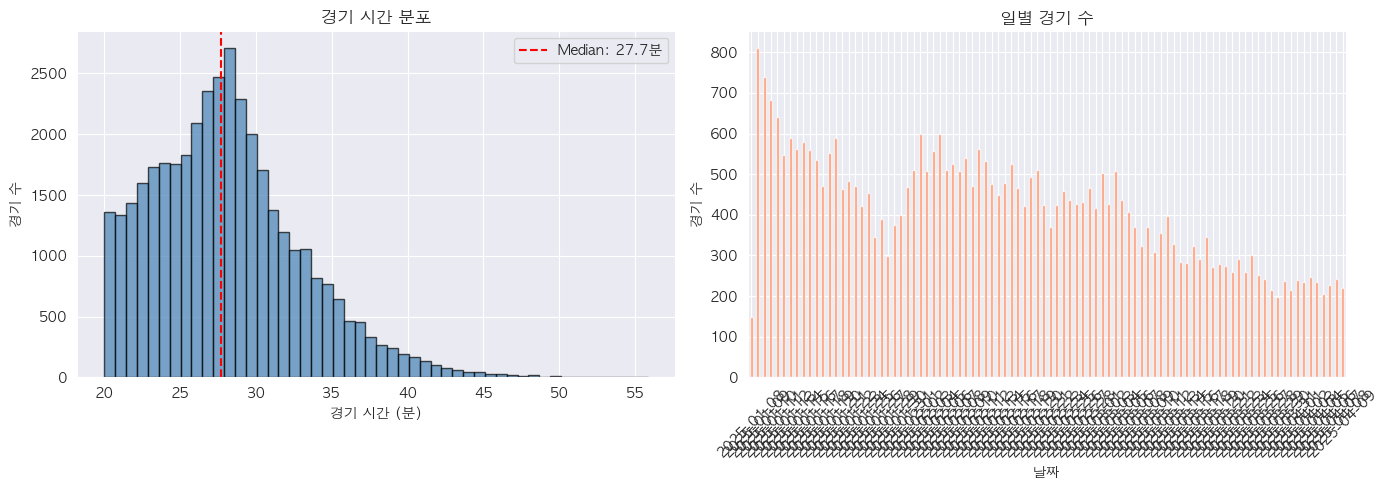


✅ 그래프 저장: output/eda_match_distribution.png


In [5]:
# 경기 시간 분석
match_df['gameDurationMin'] = match_df['gameDuration'] / 60

print("\n⏱️ 경기 시간 통계 (분):")
print(match_df['gameDurationMin'].describe().round(2))

# 경기 시간 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 경기 시간 히스토그램
axes[0].hist(match_df['gameDurationMin'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(match_df['gameDurationMin'].median(), color='red', linestyle='--', label=f"Median: {match_df['gameDurationMin'].median():.1f}분")
axes[0].set_xlabel('경기 시간 (분)')
axes[0].set_ylabel('경기 수')
axes[0].set_title('경기 시간 분포')
axes[0].legend()

# 일별 경기 수
daily_games = match_df.groupby(match_df['gameCreationDate'].dt.date).size()
daily_games.plot(kind='bar', ax=axes[1], color='coral', alpha=0.7)
axes[1].set_xlabel('날짜')
axes[1].set_ylabel('경기 수')
axes[1].set_title('일별 경기 수')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('output/eda_match_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ 그래프 저장: output/eda_match_distribution.png")

### 2.2 Match 데이터 구조 분석

In [6]:
# 샘플 데이터로 구조 분석
sample_match = load_json_file(match_files[0])
if isinstance(sample_match, list):
    sample_match = sample_match[0]

print("📋 Match 데이터 최상위 구조:")
print(f"  Keys: {list(sample_match.keys())}")

print("\n📋 metadata 구조:")
for key, value in sample_match.get('metadata', {}).items():
    if isinstance(value, list):
        print(f"  {key}: List[{len(value)} items]")
    else:
        print(f"  {key}: {type(value).__name__}")

print("\n📋 info 구조 (주요 필드):")
info = sample_match.get('info', {})
for key in ['endOfGameResult', 'gameCreation', 'gameDuration', 'gameStartTimestamp', 
            'gameEndTimestamp', 'gameMode', 'gameType', 'gameVersion', 'mapId']:
    value = info.get(key)
    print(f"  {key}: {value}")

print(f"\n  participants: List[{len(info.get('participants', []))} players]")

📋 Match 데이터 최상위 구조:
  Keys: ['metadata', 'info']

📋 metadata 구조:
  dataVersion: str
  matchId: str
  participants: List[10 items]

📋 info 구조 (주요 필드):
  endOfGameResult: GameComplete
  gameCreation: 1736310793485
  gameDuration: 1837
  gameStartTimestamp: 1736310811362
  gameEndTimestamp: 1736312648918
  gameMode: CLASSIC
  gameType: MATCHED_GAME
  gameVersion: 14.24.644.2327
  mapId: 11

  participants: List[10 players]


In [7]:
# Participant 데이터 구조
sample_participant = sample_match['info']['participants'][0]

print("📋 Participant 주요 필드:")
important_fields = [
    'participantId', 'puuid', 'teamId', 'teamPosition', 'individualPosition',
    'championId', 'championName', 'win',
    'kills', 'deaths', 'assists', 'goldEarned',
    'totalDamageDealtToChampions', 'totalDamageTaken',
    'visionScore', 'timePlayed'
]

for field in important_fields:
    value = sample_participant.get(field)
    print(f"  {field}: {value}")

print(f"\n총 필드 수: {len(sample_participant)} 개")

📋 Participant 주요 필드:
  participantId: 1
  puuid: PnjczL7VESlrLKjVSQUWgsAjCsS7r3KNJcmsq5Xb6aindkgJMMm7iJ95fLdqmMZU86jv0AGSxu-mQQ
  teamId: 100
  teamPosition: TOP
  individualPosition: TOP
  championId: 14
  championName: Sion
  win: True
  kills: 4
  deaths: 5
  assists: 13
  goldEarned: 11465
  totalDamageDealtToChampions: 21893
  totalDamageTaken: 44130
  visionScore: 21
  timePlayed: 1837

총 필드 수: 133 개


In [8]:
# 게임 모드 및 타입 분석
print("\n🎮 게임 모드 분포:")
print(match_df['gameMode'].value_counts())

print("\n🎮 게임 타입 분포:")
print(match_df['gameType'].value_counts())

print("\n🎮 경기 결과 분포:")
print(match_df['endOfGameResult'].value_counts())


🎮 게임 모드 분포:
gameMode
CLASSIC    38075
Name: count, dtype: int64

🎮 게임 타입 분포:
gameType
MATCHED_GAME    38075
Name: count, dtype: int64

🎮 경기 결과 분포:
endOfGameResult
GameComplete    38075
Name: count, dtype: int64


---
## 3. Timeline 데이터 분석 (timeline_*.json)

In [9]:
# 샘플 타임라인 로드
sample_timeline = load_json_file(timeline_files[0])
if isinstance(sample_timeline, list):
    sample_timeline = sample_timeline[0]

print("📋 Timeline 데이터 최상위 구조:")
print(f"  Keys: {list(sample_timeline.keys())}")

print("\n📋 info 구조:")
timeline_info = sample_timeline.get('info', {})
for key, value in timeline_info.items():
    if key != 'frames':
        print(f"  {key}: {value}")

frames = timeline_info.get('frames', [])
print(f"  frames: List[{len(frames)} frames]")
print(f"  (약 {len(frames)-1}분 경기)")

📋 Timeline 데이터 최상위 구조:
  Keys: ['metadata', 'info']

📋 info 구조:
  endOfGameResult: GameComplete
  frameInterval: 60000
  gameId: 7461719584
  participants: [{'participantId': 1, 'puuid': 'PnjczL7VESlrLKjVSQUWgsAjCsS7r3KNJcmsq5Xb6aindkgJMMm7iJ95fLdqmMZU86jv0AGSxu-mQQ'}, {'participantId': 2, 'puuid': 'UDY6yg4_foiB991ah-NXqpYxRn_FxFCSWU8PsV_ipW-30lv9NEuJruglQ4dfw2E9K5lrexLj2RN1Jg'}, {'participantId': 3, 'puuid': 'hVPzeZALU-SPFNYByN1YOqA16Twwxyy30i5B0AoXsVa-ADZ6UoACZxF16nYPFG4BwKHubkrWaCHTMg'}, {'participantId': 4, 'puuid': 'Xp5eXjOb1tyEBWw-zg6R9jnpnOsdZk2rC9CzNMCSW48IRhlBWKeD3Teq9BrsG7fWVnv_MrNsKQfx2Q'}, {'participantId': 5, 'puuid': 'InG-aw75ZisgsmJJ_XjOrK8BPs1ElVMwNsklk0lWIJkZCKbwve8iTzbvh4bz_vsIu4HgbYRQAUyMeQ'}, {'participantId': 6, 'puuid': '72lIpS7UXgt6zge6zZMPLUElUfqAciBjEzXx8T9wpEnvYhpQjGX5-F1_3sLwDOIyBfHj0EbP1CtbeA'}, {'participantId': 7, 'puuid': 'x5Dw8cufXrfTzw1UJmImEFbXS3IYlHXzqxu71uEqJuAzoMKry7_b3p2kH_Vkfzv__pWBG-yg7XMv2g'}, {'participantId': 8, 'puuid': 'wfD8o6pksilt-AWa_8zCT

In [10]:
# Frame 구조 분석
sample_frame = frames[5]  # 5분 시점 프레임

print("📋 Frame 구조 (5분 시점):")
print(f"  Keys: {list(sample_frame.keys())}")
print(f"  timestamp: {sample_frame.get('timestamp')} ms ({sample_frame.get('timestamp') / 60000:.1f} 분)")
print(f"  events: List[{len(sample_frame.get('events', []))} events]")
print(f"  participantFrames: Dict[{len(sample_frame.get('participantFrames', {}))} participants]")

# participantFrame 구조
pf = sample_frame['participantFrames']['1']
print("\n📋 ParticipantFrame 구조:")
print(f"  Keys: {list(pf.keys())}")
print(f"\n  주요 필드:")
print(f"    level: {pf.get('level')}")
print(f"    xp: {pf.get('xp')}")
print(f"    totalGold: {pf.get('totalGold')}")
print(f"    minionsKilled: {pf.get('minionsKilled')}")
print(f"    jungleMinionsKilled: {pf.get('jungleMinionsKilled')}")

# damageStats 분석
ds = pf.get('damageStats', {})
print(f"\n  damageStats Keys: {list(ds.keys())}")

📋 Frame 구조 (5분 시점):
  Keys: ['events', 'participantFrames', 'timestamp']
  timestamp: 300123 ms (5.0 분)
  events: List[31 events]
  participantFrames: Dict[10 participants]

📋 ParticipantFrame 구조:
  Keys: ['championStats', 'currentGold', 'damageStats', 'goldPerSecond', 'jungleMinionsKilled', 'level', 'minionsKilled', 'participantId', 'position', 'timeEnemySpentControlled', 'totalGold', 'xp']

  주요 필드:
    level: 5
    xp: 2077
    totalGold: 1702
    minionsKilled: 38
    jungleMinionsKilled: 0

  damageStats Keys: ['magicDamageDone', 'magicDamageDoneToChampions', 'magicDamageTaken', 'physicalDamageDone', 'physicalDamageDoneToChampions', 'physicalDamageTaken', 'totalDamageDone', 'totalDamageDoneToChampions', 'totalDamageTaken', 'trueDamageDone', 'trueDamageDoneToChampions', 'trueDamageTaken']


In [11]:
# 이벤트 타입 분석
all_event_types = []
for frame in frames:
    for event in frame.get('events', []):
        all_event_types.append(event.get('type'))

event_counts = Counter(all_event_types)
print("📋 Event 타입 분포 (단일 경기):")
for event_type, count in event_counts.most_common(15):
    print(f"  {event_type}: {count}")

📋 Event 타입 분포 (단일 경기):
  ITEM_PURCHASED: 250
  WARD_PLACED: 200
  ITEM_DESTROYED: 197
  SKILL_LEVEL_UP: 148
  LEVEL_UP: 138
  WARD_KILL: 91
  CHAMPION_KILL: 66
  BUILDING_KILL: 14
  ITEM_SOLD: 13
  ELITE_MONSTER_KILL: 12
  CHAMPION_SPECIAL_KILL: 11
  TURRET_PLATE_DESTROYED: 5
  ITEM_UNDO: 4
  PAUSE_END: 1
  OBJECTIVE_BOUNTY_PRESTART: 1


---
## 4. Match ID 일치 검증

In [12]:
# 첫 번째 파일 쌍으로 검증
match_id_from_match = sample_match['metadata']['matchId']
match_id_from_timeline = sample_timeline['metadata']['matchId']

print("🔍 Match ID 일치 검증:")
print(f"  match_1.json matchId: {match_id_from_match}")
print(f"  timeline_1.json matchId: {match_id_from_timeline}")
print(f"  일치 여부: {'✅ 일치' if match_id_from_match == match_id_from_timeline else '❌ 불일치'}")

🔍 Match ID 일치 검증:
  match_1.json matchId: KR_7461719584
  timeline_1.json matchId: KR_7461719584
  일치 여부: ✅ 일치


---
## 5. 요약 및 결론

In [13]:
print("=" * 60)
print("📊 Raw Data EDA 요약")
print("=" * 60)

print(f"\n🎮 총 경기 수: {len(match_df)}")
print(f"📅 경기 기간: {start_date} ~ {end_date}")
print(f"⏱️ 평균 경기 시간: {match_df['gameDurationMin'].mean():.1f}분")
print(f"📁 데이터 용량: {(sum(match_sizes) + sum(timeline_sizes))/1024:.2f} GB")

print("\n📋 Match 데이터 (match_*.json):")
print("  - matchId, gameCreation, gameDuration, gameStartTimestamp, gameEndTimestamp")
print("  - participants: 10명 (5v5)")
print("  - 각 플레이어별 상세 스탯 (kills, deaths, assists, gold 등)")

print("\n📋 Timeline 데이터 (timeline_*.json):")
print("  - frameInterval: 60000ms (1분 간격)")
print("  - frames: 분 단위 스냅샷")
print("  - participantFrames: 각 플레이어의 실시간 상태")
print("  - events: 킬, 어시스트, 와드, 오브젝트 등")

print("\n✅ 시간별 기여도 분석을 위해:")
print("  gameStartTimestamp를 all_positions_features.csv에 추가하면")
print("  puuid별로 시간 경과에 따른 기여도 변화를 분석할 수 있습니다.")

📊 Raw Data EDA 요약

🎮 총 경기 수: 38075
📅 경기 기간: 2025.01.08 ~ 2025.04.09
⏱️ 평균 경기 시간: 28.1분
📁 데이터 용량: 70.06 GB

📋 Match 데이터 (match_*.json):
  - matchId, gameCreation, gameDuration, gameStartTimestamp, gameEndTimestamp
  - participants: 10명 (5v5)
  - 각 플레이어별 상세 스탯 (kills, deaths, assists, gold 등)

📋 Timeline 데이터 (timeline_*.json):
  - frameInterval: 60000ms (1분 간격)
  - frames: 분 단위 스냅샷
  - participantFrames: 각 플레이어의 실시간 상태
  - events: 킬, 어시스트, 와드, 오브젝트 등

✅ 시간별 기여도 분석을 위해:
  gameStartTimestamp를 all_positions_features.csv에 추가하면
  puuid별로 시간 경과에 따른 기여도 변화를 분석할 수 있습니다.


---
## 6. 📁 gameStartTimestamp 추가 함수

아래 코드를 실행하면 `all_positions_features.csv`에 `gameStartTimestamp` 컬럼이 추가됩니다.

In [14]:
def add_game_timestamp_to_features(features_path='data/all_positions_features.csv', 
                                    output_path='data/all_positions_features_with_time.csv'):
    """
    all_positions_features.csv에 gameStartTimestamp 컬럼 추가
    시간에 따른 기여도 분석에 사용
    """
    print("Loading features CSV...")
    features_df = pd.read_csv(features_path)
    print(f"  Loaded {len(features_df)} rows")
    
    # Match ID별 gameStartTimestamp 매핑 생성
    print("\nCreating matchId -> gameStartTimestamp mapping...")
    timestamp_mapping = {}
    
    for i, match_file in enumerate(match_files):
        try:
            data = load_json_file(match_file)
            if isinstance(data, list):
                for match in data:
                    match_id = match['metadata']['matchId']
                    timestamp = match['info'].get('gameStartTimestamp')
                    timestamp_mapping[match_id] = timestamp
            else:
                match_id = data['metadata']['matchId']
                timestamp = data['info'].get('gameStartTimestamp')
                timestamp_mapping[match_id] = timestamp
        except Exception as e:
            print(f"Error: {match_file}: {e}")
        
        if (i + 1) % 200 == 0:
            print(f"  Processed {i + 1}/{len(match_files)} files...")
    
    print(f"  Created mapping for {len(timestamp_mapping)} matches")
    
    # features CSV에 timestamp 추가
    print("\nAdding gameStartTimestamp to features...")
    features_df['gameStartTimestamp'] = features_df['matchId'].map(timestamp_mapping)
    features_df['gameStartDate'] = pd.to_datetime(features_df['gameStartTimestamp'], unit='ms')
    
    # 결과 저장
    features_df.to_csv(output_path, index=False)
    print(f"\n✅ Saved to {output_path}")
    print(f"   Total rows: {len(features_df)}")
    print(f"   New columns: gameStartTimestamp, gameStartDate")
    
    return features_df

# 실행 (주석 해제하여 사용)
# features_with_time = add_game_timestamp_to_features()

In [15]:
# 위 함수를 실행하면 아래와 같이 시간에 따른 분석이 가능합니다.
# 예시:
# features_with_time = add_game_timestamp_to_features()
# 
# # 특정 puuid의 시간에 따른 기여도 변화 분석
# target_puuid = "PnjczL7VESlrLKjVSQUWgsAjCsS7r3KNJcmsq5Xb6aindkgJMMm7iJ95fLdqmMZU86jv0AGSxu-mQQ"
# player_data = features_with_time[features_with_time['puuid'] == target_puuid]
# player_data = player_data.sort_values('gameStartDate')
# 
# # 경기별 평균 KDA, damageShare 등 시간 추이 분석 가능
# player_stats = player_data.groupby('matchId').agg({
#     'gameStartDate': 'first',
#     'KDA': 'max',  # 경기 종료 시점
#     'damageShare': 'max',
#     'killParticipation': 'max'
# }).sort_values('gameStartDate')

print("💡 Tip: 위 코드 블록의 주석을 해제하여 실행하면")
print("   all_positions_features.csv에 게임 시작 시간이 추가됩니다.")

💡 Tip: 위 코드 블록의 주석을 해제하여 실행하면
   all_positions_features.csv에 게임 시작 시간이 추가됩니다.
